# Ejercicio 2

In [1]:
# Descargamos el archivo "misutmeeple.com_2018_08_resena-sagrada.txt"
!gdown 1n3ykrZFdDGZPjAQovvrSgPR3cBZAvZ5R

Downloading...
From: https://drive.google.com/uc?id=1n3ykrZFdDGZPjAQovvrSgPR3cBZAvZ5R
To: /content/misutmeeple.com_2018_08_resena-sagrada.txt
100% 58.2k/58.2k [00:00<00:00, 68.8MB/s]


### **Una vez ejecutada esta celda, reiniciar el entorno**

In [2]:
!pip uninstall -y numpy scipy scikit-learn transformers
!pip install numpy==1.26.4
!pip install scipy scikit-learn transformers
!pip install -U spacy
!python -m spacy download es_core_news_sm

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 63.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-pandas 2.2.0 requires scikit-learn>=0.23.0, which is not installed.
sklearn-pandas 2.2.0 requires scipy>=1.5.1, which is not installed.
jax 0.5.2 requires scipy>=1.11.1, which is not ins

In [2]:
import numpy as np
import scipy
import sklearn
import transformers

print("numpy:", np.__version__)
print("scipy:", scipy.__version__)
print("sklearn:", sklearn.__version__)
print("transformers:", transformers.__version__)


numpy: 2.2.6
scipy: 1.15.3
sklearn: 1.6.1
transformers: 4.52.2


In [3]:
from sentence_transformers import SentenceTransformer
import numpy as np
import spacy

# Cargar modelo spaCy en español
nlp = spacy.load('es_core_news_sm')

# Cargar el modelo SentenceTransformer multilingüe optimizado para embeddings
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Leer el archivo de texto
with open('misutmeeple.com_2018_08_resena-sagrada.txt', 'r', encoding='utf-8') as file:
    full_text = file.read()

# Función para dividir el texto en fragmentos usando spaCy (por oraciones)
def split_text_into_chunks_spacy(text):
    doc = nlp(text)
    # Extraemos cada oración como un fragmento limpio
    return [sent.text.strip() for sent in doc.sents]

# Dividir el texto en fragmentos
text_chunks = split_text_into_chunks_spacy(full_text)
print(f"Se han creado {len(text_chunks)} fragmentos de texto")

# Obtener embeddings de todos los fragmentos a la vez (más eficiente)
embeddings = model.encode(text_chunks, convert_to_numpy=True, show_progress_bar=True)

# Normalizar embeddings para similitud coseno
def normalize(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / np.where(norms == 0, 1, norms)

normalized_embeddings = normalize(embeddings)

# Función para calcular similitud coseno entre vectores normalizados
def calculate_cosine_similarity(emb1, emb2):
    return np.dot(emb1, emb2)

# Función para calcular distancia euclidiana entre vectores (sin normalizar)
def calculate_euclidean_distance(emb1, emb2):
    return np.linalg.norm(emb1 - emb2)

# Guardar resultados para análisis posterior
cosine_similarity_results = []

# Función para buscar fragmentos más similares a una frase dada
def buscar_similares(frase, top_k=1):
    frase_embedding = model.encode([frase], convert_to_numpy=True)[0]
    frase_embedding_norm = frase_embedding / np.linalg.norm(frase_embedding)

    # Similitud coseno (vectores normalizados)
    similitudes_coseno = [calculate_cosine_similarity(frase_embedding_norm, emb) for emb in normalized_embeddings]

    # Distancia euclidiana (vectores sin normalizar)
    distancias_euclid = [calculate_euclidean_distance(frase_embedding, emb) for emb in embeddings]

    # Top-k por similitud coseno
    top_coseno_indices = np.argsort(similitudes_coseno)[::-1][:top_k]
    print(f"Fragmento según Similitud Coseno para la frase: \"{frase}\"")
    for idx in top_coseno_indices:
        print(f" - Fragmento {idx + 1} con similitud coseno {similitudes_coseno[idx]:.4f}")
        print(f"   {text_chunks[idx][:200]}...\n")
        cosine_similarity_results.append((frase, idx, similitudes_coseno[idx], text_chunks[idx]))

    # Top-k por distancia euclidiana
    top_euclid_indices = np.argsort(distancias_euclid)[:top_k]
    print(f"Fragmento según Distancia Euclidiana para la frase: \"{frase}\"")
    for idx in top_euclid_indices:
        print(f" - Fragmento {idx + 1} con distancia euclidiana {distancias_euclid[idx]:.4f}")
        print(f"   {text_chunks[idx][:200]}...\n")


# Top 10 global mostrando frase / fragmento / similitud
def mostrar_top_10_global():
    print("\n===== Top 10 Global (frase / fragmento / similitud coseno) =====")

    max_sim_por_fragmento = {}
    for frase, idx, sim, frag in cosine_similarity_results:
        if idx not in max_sim_por_fragmento or sim > max_sim_por_fragmento[idx][0]:
            max_sim_por_fragmento[idx] = (sim, frag, frase)

    top_10 = sorted(max_sim_por_fragmento.items(), key=lambda x: x[1][0], reverse=True)[:10]
    for i, (idx, (sim, frag, frase)) in enumerate(top_10, 1):
        print(f"{i}. Frase: \"{frase}\"")
        print(f"   Fragmento {idx + 1} - Similitud coseno: {sim:.4f}")
        print(f"   {frag[:200]}...\n")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Se han creado 492 fragmentos de texto


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

## 2.1 Análisis de similitud de texto

In [4]:
# Frases ejemplo para buscar similares
ejemplos = [
    # Relacionadas con el juego
    "el diseño del juego es hermoso",
    "cómo se puntúan los dados",
    "las reglas son fáciles de aprender",
    "Sagrada es un juego de dados estratégico y visualmente atractivo",
    "el tablero de vitrales es muy colorido",
    "cada jugador tiene que elegir cuidadosamente sus dados",
    "las cartas de herramienta permiten modificar el resultado",
    "el azar influye pero hay decisiones estratégicas",
    "es ideal para jugar en familia o con amigos",
    "la interacción entre jugadores es limitada pero presente",

    # No relacionadas
    "Colapinto va a ser campeón mundial de la fórmula 1 en Alpine",
    "el motor de un auto eléctrico requiere menos mantenimiento",
    "Rosario Central es el club de futbol mas grande del interior por amplia diferencia",
    "el clima en Rosario estará lluvioso toda la semana",
    "Python es un lenguaje popular para la inteligencia artificial",
    "el telescopio James Webb capturó nuevas galaxias lejanas",
    "la inflación afecta el precio de los productos básicos",
    "en Japón se celebra el hanami en primavera",
    "los agujeros negros tienen una gravedad extrema",
    "el ajedrez fue inventado hace siglos en la India"
]


for frase in ejemplos:
    buscar_similares(frase)

Fragmento según Similitud Coseno para la frase: "el diseño del juego es hermoso"
 - Fragmento 398 con similitud coseno 0.6599
   muy recomendable la compra de este juego....

Fragmento según Distancia Euclidiana para la frase: "el diseño del juego es hermoso"
 - Fragmento 398 con distancia euclidiana 3.3262
   muy recomendable la compra de este juego....

Fragmento según Similitud Coseno para la frase: "cómo se puntúan los dados"
 - Fragmento 145 con similitud coseno 0.6475
   Cuando sea nuestro turno de escoger un dado, ahí estará ese yo interior centrado en la obtención de puntos, enfocando nuestra atención sobre los dados que nos faltan para completar los patrones....

Fragmento según Distancia Euclidiana para la frase: "cómo se puntúan los dados"
 - Fragmento 145 con distancia euclidiana 2.9738
   Cuando sea nuestro turno de escoger un dado, ahí estará ese yo interior centrado en la obtención de puntos, enfocando nuestra atención sobre los dados que nos faltan para completar los pa

### Similitud de coseno vs Distancia Euclidiana


1. **Similitud de coseno** es mejor porque compara la orientación semántica entre vectores, ignorando su tamaño, y por eso refleja mejor la relación de significado entre la frase buscada y los fragmentos.

2. **Distancia Euclidiana** puede penalizar fragmentos por diferencias de tamaño o
frecuencia, lo que puede no ser deseable en la comparación semántica de textos.

In [5]:
mostrar_top_10_global()


===== Top 10 Global (frase / fragmento / similitud coseno) =====
1. Frase: "las cartas de herramienta permiten modificar el resultado"
   Fragmento 46 - Similitud coseno: 0.7302
   Son cartas que muestran habilidades que, en la mayoría de los casos, permiten alterar el valor o posición de los dados, a veces incluso rompiendo las restricciones anteriormente comentadas....

2. Frase: "Sagrada es un juego de dados estratégico y visualmente atractivo"
   Fragmento 21 - Similitud coseno: 0.7042
   Sagrada es un juego con mecánicas principales de draft de dados y construcción de patrones....

3. Frase: "la interacción entre jugadores es limitada pero presente"
   Fragmento 177 - Similitud coseno: 0.6883
   Más de una vez los intereses de los jugadores ni se cruzarán....

4. Frase: "cada jugador tiene que elegir cuidadosamente sus dados"
   Fragmento 30 - Similitud coseno: 0.6837
   A lo largo de las rondas, los jugadores deberán ir tomando dados de un suministro común que se coloca en el ce

## 2.2 visualización 3D (PCA y t-SNE)

In [6]:
import plotly.graph_objs as go
import plotly.express as px
from sklearn.decomposition import PCA
import numpy as np

def visualizar_pca_3d_plotly(queries, embeddings_fragmentos, embeddings_queries, text_chunks):
    # Concatenar embeddings fragmentos + queries
    X = np.vstack([embeddings_fragmentos, embeddings_queries])

    # Reducir dimensionalidad con PCA a 3 dimensiones
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    num_fragmentos = embeddings_fragmentos.shape[0]
    num_queries = embeddings_queries.shape[0]

    # Índices para fragmentos y queries
    fragmentos_idx = range(num_fragmentos)
    queries_idx = range(num_fragmentos, num_fragmentos + num_queries)

    # Fragmentos: puntos azules con baja opacidad
    trace_fragmentos = go.Scatter3d(
        x=X_pca[fragmentos_idx, 0],
        y=X_pca[fragmentos_idx, 1],
        z=X_pca[fragmentos_idx, 2],
        mode='markers',
        marker=dict(size=4, color='blue', opacity=0.3),
        name='Fragmentos'
    )

    # Queries: puntos con colores distintos y etiquetas (primeras 3 palabras)
    traces_queries = []
    colores = px.colors.qualitative.Dark24  # Paleta con suficientes colores

    for i, idx in enumerate(queries_idx):
        label = ' '.join(queries[i].split()[:3])  # Primeras 3 palabras
        trace = go.Scatter3d(
            x=[X_pca[idx, 0]],
            y=[X_pca[idx, 1]],
            z=[X_pca[idx, 2]],
            mode='markers+text',
            marker=dict(size=8, color=colores[i % len(colores)]),
            text=[label],
            textposition='top center',
            name=label
        )
        traces_queries.append(trace)

    data = [trace_fragmentos] + traces_queries

    layout = go.Layout(
        title="Visualización PCA 3D: Fragmentos y Queries",
        scene=dict(
            xaxis_title='PC1',
            yaxis_title='PC2',
            zaxis_title='PC3',
        ),
        legend=dict(itemsizing='constant')
    )

    fig = go.Figure(data=data, layout=layout)
    fig.show()

embeddings_queries = model.encode(ejemplos, convert_to_numpy=True)
visualizar_pca_3d_plotly(ejemplos, embeddings, embeddings_queries, text_chunks)


# Ejercicio 3

In [15]:
!gdown 1pGUB6uytZ9O6J2wZEPxS06yyHD1uUgew

Downloading...
From: https://drive.google.com/uc?id=1pGUB6uytZ9O6J2wZEPxS06yyHD1uUgew
To: /content/Rahdo Runs Through►►► Sagrada  Video  BoardGameGeek.txt
100% 35.4k/35.4k [00:00<00:00, 58.0MB/s]


In [16]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 1.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [17]:
pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 54.5 MB/s eta 0:00:00


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import Levenshtein

# 1. Cargar modelo spaCy para inglés
nlp = spacy.load('en_core_web_sm')

# 2. Leer texto extenso
with open('Rahdo Runs Through►►► Sagrada  Video  BoardGameGeek.txt', 'r', encoding='utf-8') as file:
    full_text = file.read()

# 3. Función para dividir en fragmentos por oraciones con spaCy
def split_text_into_chunks_spacy(text):
    doc = nlp(text)
    return [sent.text.strip() for sent in doc.sents]

# 4. Dividir texto en fragmentos
text_chunks = split_text_into_chunks_spacy(full_text)
print(f"Se han creado {len(text_chunks)} fragmentos de texto")

# 5. Extraer sustantivos (POS) y entidades (NER) por fragmento
def extract_pos_ner(text_chunks):
    results = []
    for i, chunk in enumerate(text_chunks):
        doc = nlp(chunk)
        # Sustantivos: POS == NOUN or PROPN
        nouns = [token.text for token in doc if token.pos_ in ('NOUN', 'PROPN')]
        # Entidades nombradas con su etiqueta
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        results.append({
            'fragmento': chunk,
            'sustantivos': nouns,
            'entidades': entities
        })
    return results

extracciones = extract_pos_ner(text_chunks)

# Preparar lista solo con sustantivos por fragmento (como string)
text_nouns = [' '.join(item['sustantivos']) for item in extracciones]

# Métricas de similitud

def similitud_coseno(text1, text2, vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer()
        tfidf = vectorizer.fit_transform([text1, text2])
    else:
        tfidf = vectorizer.transform([text1, text2])
    return cosine_similarity(tfidf[0], tfidf[1])[0][0]

def distancia_jaccard(text1, text2):
    set1 = set(text1.split())
    set2 = set(text2.split())
    interseccion = set1.intersection(set2)
    union = set1.union(set2)
    return len(interseccion) / len(union) if union else 0

def distancia_levenshtein(text1, text2):
    dist = Levenshtein.distance(text1, text2)
    max_len = max(len(text1), len(text2))
    return 1 - dist / max_len if max_len > 0 else 1

def similitud_dice(text1, text2):
    set1 = set(text1.split())
    set2 = set(text2.split())
    interseccion = 2 * len(set1.intersection(set2))
    suma = len(set1) + len(set2)
    return interseccion / suma if suma > 0 else 0

def similitud_jaro_winkler(text1, text2):
    return Levenshtein.jaro_winkler(text1, text2)

# Búsqueda de fragmentos similares según sustantivos

def buscar_similares(frase, top_k=3):
    # Extraer sustantivos de la consulta
    doc_query = nlp(frase)
    query_nouns = ' '.join([token.text for token in doc_query if token.pos_ in ('NOUN', 'PROPN')])
    if not query_nouns:
        print("No se encontraron sustantivos en la consulta.")
        return

    # Crear vectorizador TF-IDF para coseno
    vectorizer = TfidfVectorizer()
    vectorizer.fit(text_nouns + [query_nouns])

    # Calcular similitudes con cada métrica
    results = {
        'coseno': [],
        'jaccard': [],
        'levenshtein': [],
        'dice': [],
        'jaro_winkler': []
    }

    for idx, tn in enumerate(text_nouns):
        results['coseno'].append((idx, similitud_coseno(query_nouns, tn, vectorizer)))
        results['jaccard'].append((idx, distancia_jaccard(query_nouns, tn)))
        results['levenshtein'].append((idx, distancia_levenshtein(query_nouns, tn)))
        results['dice'].append((idx, similitud_dice(query_nouns, tn)))
        results['jaro_winkler'].append((idx, similitud_jaro_winkler(query_nouns, tn)))

    # Mostrar top_k resultados por métrica
    for metric, values in results.items():
        print(f"\nTop {top_k} fragmentos similares según {metric}:")
        top = sorted(values, key=lambda x: x[1], reverse=True)[:top_k]
        for idx, score in top:
            print(f"Fragmento #{idx+1} - Score: {score:.4f}")
            print(f"Texto: {extracciones[idx]['fragmento']}\n")

# --- Ejemplo de búsqueda ---
consulta = "Board game review with strategy and components"
buscar_similares(consulta, top_k=3)


Se han creado 296 fragmentos de texto

Top 3 fragmentos similares según coseno:
Fragmento #13 - Score: 0.3153
Texto: so I that's what we're
shooting for this game

Fragmento #72 - Score: 0.1845
Texto: I'm definitely going to want
that although oh my gosh come on game so
remember I want purples a purple finally
comes out and it's a four

Fragmento #6 - Score: 0.1719
Texto: so we already
got the game set up here it was G to be
a two-player game this is my stained
glass piece I'm trying to build this is
Jen's and actually the real game I
should say everything you're seeing here
is prototypes the real game according to
these prototype rules i h mentioned show
that there's going to be this very very
cool dice tray holder that looks like a
big gigantic piece of stained glass and
it keeps your dice from you know
accidentally jostling around not now my
prototype of course I don't have one of
those I've just got the card and in fact
the game comes with a bunch of different
cards to uh ensure th

La métrica de similitud del coseno con TF-IDF es la que mejor se ajusta para este tipo de búsqueda porque:

1. Captura la importancia relativa de cada término, ignorando los irrelevantes (como artículos o conectores).

2. Escala correctamente a fragmentos largos, donde otras métricas basadas en tokens fallan.

3. Produce resultados semánticamente coherentes: los fragmentos top contienen conceptos como “stained glass”, “dice tray”, “build”, que están alineados con la temática del juego mencionado en la consulta.

4. Otras métricas (como Jaccard o Dice) tienen dificultades en capturar la riqueza semántica y tienden a repetir fragmentos de bajo contenido.

# Ejercicio 4

**Instrucciones para copiar la carpeta de datos en tu Google Drive**
1. Abrir el Google Drive propio (https://drive.google.com).

2. Entrar al repositorio de drive de Sagrada (https://drive.google.com/drive/folders/1EXw11S1WbPRtjTJDS8JyisaAiBDcA3iW?usp=sharing).

3. Hacer clic derecho sobre la carpeta y seleccionar la opción “Añadir acceso directo a Drive” o “Agregar a Mi unidad” para que la carpeta aparezca en el Drive personal.

  - Si no aparece esta opción, hacer clic derecho en la carpeta, despues elegir “Hacer una copia” para crear una copia completa en tu Drive.

4. Verificar que la carpeta esté en el Drive personal, por ejemplo dentro de “Mi unidad”.

5. Cuando se ejecute el notebook, montar tu Drive con:

```python
from google.colab import drive
drive.mount('/content/drive')\
```

Indicar la ruta donde está la carpeta copiada en el Drive. Por ejemplo:

```python
/content/drive/MyDrive/NombreDeLaCarpeta
```
El código recorrerá esa carpeta y procesará los archivos correctamente.

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
!pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 26.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=a9b69fd5caebf73f254c4de7317929b09c3d58fbb3510d49039b1e5b94bd6847
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [21]:
import os
import pandas as pd
from langdetect import detect

# Ruta base donde están las carpetas
base_path = '/content/drive/MyDrive/Sagrada-Nlp/sagrada-main/datos'

# Definir extensiones que interesan por cada carpeta
extensiones = {
    'estadisticas': ['.csv'],
    'informacion': ['.csv', '.txt'],
    'relaciones': ['.csv']
}

# Lista para guardar resultados
resultados = []

# Función para leer contenido según extensión
def leer_contenido(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            return f.read()
    except Exception as e:
        print(f'Error leyendo {filepath}: {e}')
        return ""

# Recorrer carpetas y archivos
for carpeta, exts in extensiones.items():
    folder_path = os.path.join(base_path, carpeta)
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in exts):
                filepath = os.path.join(root, file)
                texto = leer_contenido(filepath)
                if texto.strip():  # si no está vacío
                    try:
                        idioma = detect(texto)
                    except:
                        idioma = 'unknown'
                    resultados.append({
                        'carpeta': carpeta,
                        'archivo': filepath,
                        'idioma': idioma
                    })

# Crear DataFrame con resultados
df = pd.DataFrame(resultados)
print(df)

# Guardar el DataFrame en csv
df.to_csv('resultado_idiomas.csv', index=False)

         carpeta                                            archivo idioma
0   estadisticas  /content/drive/MyDrive/Sagrada-Nlp/sagrada-mai...     en
1   estadisticas  /content/drive/MyDrive/Sagrada-Nlp/sagrada-mai...     en
2   estadisticas  /content/drive/MyDrive/Sagrada-Nlp/sagrada-mai...     en
3   estadisticas  /content/drive/MyDrive/Sagrada-Nlp/sagrada-mai...     en
4   estadisticas  /content/drive/MyDrive/Sagrada-Nlp/sagrada-mai...     en
5    informacion  /content/drive/MyDrive/Sagrada-Nlp/sagrada-mai...     es
6    informacion  /content/drive/MyDrive/Sagrada-Nlp/sagrada-mai...     en
7    informacion  /content/drive/MyDrive/Sagrada-Nlp/sagrada-mai...     en
8    informacion  /content/drive/MyDrive/Sagrada-Nlp/sagrada-mai...     en
9    informacion  /content/drive/MyDrive/Sagrada-Nlp/sagrada-mai...     en
10   informacion  /content/drive/MyDrive/Sagrada-Nlp/sagrada-mai...     en
11   informacion  /content/drive/MyDrive/Sagrada-Nlp/sagrada-mai...     es
12   informacion  /conten

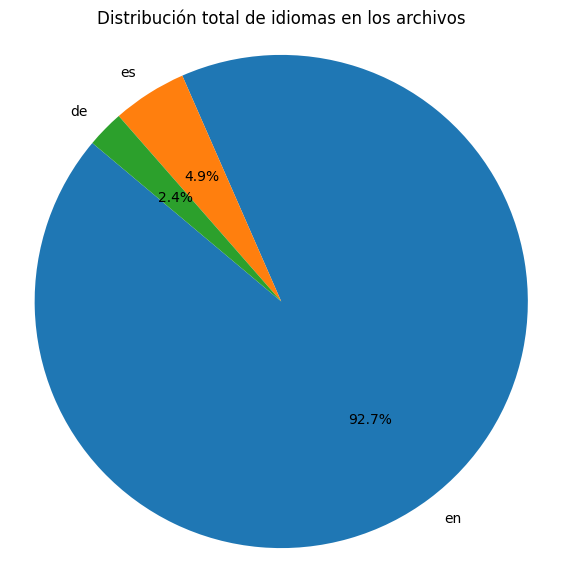

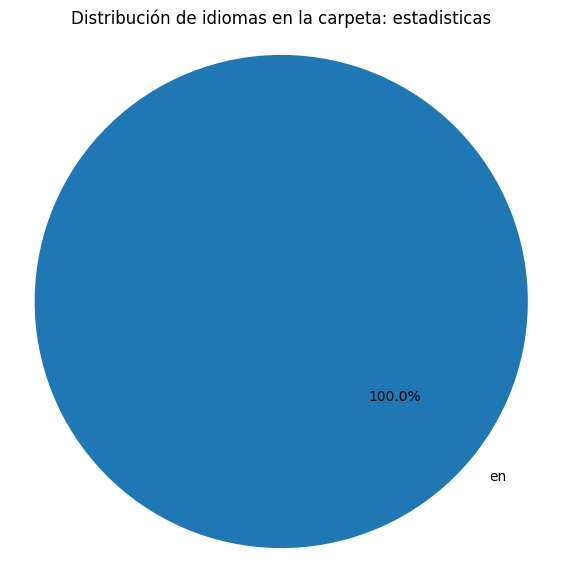

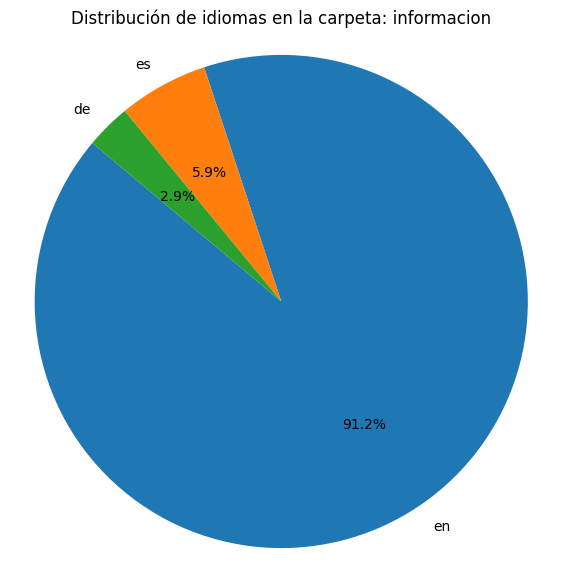

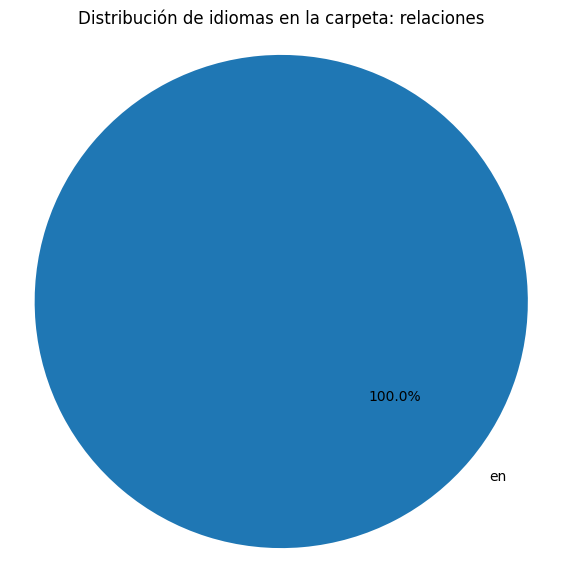

In [22]:
import matplotlib.pyplot as plt

# Gráfico torta total de idiomas
idioma_counts = df['idioma'].value_counts()
plt.figure(figsize=(7,7))
plt.pie(idioma_counts, labels=idioma_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución total de idiomas en los archivos')
plt.axis('equal')
plt.show()

# Gráfico torta de idiomas por carpeta
carpetas = df['carpeta'].unique()

for carpeta in carpetas:
    subset = df[df['carpeta'] == carpeta]
    counts = subset['idioma'].value_counts()
    plt.figure(figsize=(7,7))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Distribución de idiomas en la carpeta: {carpeta}')
    plt.axis('equal')
    plt.show()


# EJERCICIO 5

In [23]:
!gdown 1tn0dBUgIeeSNO6OJ6A7v_Cy4kAJqaOv4

Downloading...
From: https://drive.google.com/uc?id=1tn0dBUgIeeSNO6OJ6A7v_Cy4kAJqaOv4
To: /content/Sagrada-Ratings_Reseñas.csv
100% 253k/253k [00:00<00:00, 17.2MB/s]


Utilizamos "BertForSequenceClassification" ya que las reseñas estan en varios lenguajes y este es un modelo multilingue

In [24]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

# Cargar del modelo y tokenizador
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Cargar el archivo CSV
df = pd.read_csv("Sagrada-Ratings_Reseñas.csv")

# Aplicar análisis de sentimiento
def analizar_sentimiento(texto):
    try:
        resultado = sentiment_pipeline(texto[:512])[0]  # Limita a 512 tokens
        return resultado['label'], round(resultado['score'], 3)
    except Exception as e:
        return "error", 0.0

# Crear nuevas columnas con los resultados
df[['sentimiento_predicho', 'score_predicho']] = df['reseña'].apply(
    lambda x: pd.Series(analizar_sentimiento(str(x)))
)

# Guardar el resultado en un nuevo CSV
df.to_csv("Sagrada-Ratings_Reseñas_ConSentimiento.csv", index=False)
print("Archivo guardado como 'Sagrada-Ratings_Reseñas_ConSentimiento.csv'")


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Archivo guardado como 'Sagrada-Ratings_Reseñas_ConSentimiento.csv'


In [25]:
df = pd.read_csv("Sagrada-Ratings_Reseñas_ConSentimiento.csv")
df.head(15)

,puntaje,reseña,sentimiento_predicho,score_predicho
0,7.0,"Mostly played on the App, both solo and agains...",4 stars,0.532
1,9.0,"The stunning components elevate it to a 9, but...",4 stars,0.497
2,8.0,"Great great game. Good to look at, good to pla...",5 stars,0.628
3,NaN,Kickstarter edition w/ Kickstarter player boar...,5 stars,0.462
4,10.0,"Świetna gra, która początkowo nie wiedzieć dla...",4 stars,0.644
5,7.0,July 2022\nTraded to BoardGameCo for 34 points...,1 star,0.281
6,10.0,This is so clever. Dice as stained glass windo...,5 stars,0.484
7,NaN,"Secret Colour, Goal 1, Goal 2, Goal 3, Num Tok...",1 star,0.260
8,7.0,Includes Sagrada: Promo 2 – Alpenglow/Komorebi...,4 stars,0.259
9,8.0,Simple and elegant design. Your decision are i...,4 stars,0.566


Interpretacion de "sentimiento_predicho"

| sentimiento_predicho | Significado (interpretación)     |
|----------------------|----------------------------------|
| "1 star"             | Sentimiento muy negativo         |
| "2 stars"            | Sentimiento negativo             |
| "3 stars"            | Sentimiento neutral              |
| "4 stars"            | Sentimiento positivo             |
| "5 stars"            | Sentimiento muy positivo         |


El score_predicho es la confianza o probabilidad que el modelo asigna a la predicción del sentimiento.

In [26]:
from sentence_transformers import SentenceTransformer, util
import torch

df = pd.read_csv("Sagrada-Ratings_Reseñas_ConSentimiento.csv")

# Cargar modelo para embeddings semánticos
embedder = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Generar embeddings de todas las reseñas como arrays de numpy
embeddings = embedder.encode(df['reseña'].tolist(), convert_to_numpy=True)

# Función para calcular similitud de coseno usando numpy
def calcular_similitud_coseno(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Función para buscar reseñas similares por consulta y filtrar por sentimiento
def buscar_reseñas_por_similitud(texto_consulta, sentimiento_filtro=None, top_k=5):
    query_embedding = embedder.encode(texto_consulta, convert_to_numpy=True)

    # Calcular similitudes coseno con numpy
    similitudes = np.array([
        calcular_similitud_coseno(query_embedding, emb) for emb in embeddings
    ])

    # Obtener los índices de los top_k más similares (ordenados de mayor a menor)
    top_indices = np.argsort(similitudes)[::-1]

    resultados = []
    for idx in top_indices:
        if sentimiento_filtro is None or df.loc[idx, 'sentimiento_predicho'] == sentimiento_filtro:
            resultados.append({
                'reseña': df.loc[idx, 'reseña'],
                'puntaje': df.loc[idx, 'puntaje'] if 'puntaje' in df.columns else None,
                'sentimiento_predicho': df.loc[idx, 'sentimiento_predicho'],
                'score_predicho': df.loc[idx, 'score_predicho'],
                'similitud': similitudes[idx]
            })
        if len(resultados) == top_k:
            break

    return resultados


### Consulta para filtrar semanticamente

In [27]:
consulta = input("Ingrese su consulta: ")

filtro_sentimiento = input(
    "Ingrese filtro de sentimiento (ejemplo: '1 star', '5 stars') o deje vacío para no filtrar: "
).strip()

if filtro_sentimiento == "":
    filtro_sentimiento = None

resultados_busqueda = buscar_reseñas_por_similitud(consulta, filtro_sentimiento, top_k=5)

for r in resultados_busqueda:
    print(f"Similitud: {r['similitud']:.3f} | Sentimiento: {r['sentimiento_predicho']} | Puntaje: {r['puntaje']}")
    print(f"Reseña: {r['reseña']}")
    print("-" * 80)


Ingrese su consulta: el juego es malo
Ingrese filtro de sentimiento (ejemplo: '1 star', '5 stars') o deje vacío para no filtrar: 2 stars
Similitud: 0.638 | Sentimiento: 2 stars | Puntaje: 4.0
Reseña: Liked it at 2 players, but playing with more people really turned me off this game, very frustrating with all the luck and chaos.
--------------------------------------------------------------------------------
Similitud: 0.619 | Sentimiento: 2 stars | Puntaje: 7.0
Reseña: The main problem with this game is I wish I could eat the dice.
--------------------------------------------------------------------------------
Similitud: 0.616 | Sentimiento: 2 stars | Puntaje: 5.0
Reseña: I've only had one playthrough, and there was a poor explanation of the rules, which caused my late-game to tank hard.
Still, with the dice-rolling and placement, it's fine in the beginning, as you have options, but as the board fills up, you're very much at the mercy of the dice and I really don't like that feeling.


# Ejercicio 6

In [28]:
!gdown 1-q8IyIY2eE2p3tuPmHRYP111UdKb-U0h

Downloading...
From: https://drive.google.com/uc?id=1-q8IyIY2eE2p3tuPmHRYP111UdKb-U0h
To: /content/sagrada_questions.csv
100% 17.6k/17.6k [00:00<00:00, 53.3MB/s]


### Creacion del dataset

In [29]:
#Cargamos el set de preguntas ya generadas y categorizadas
questions = pd.read_csv("sagrada_questions.csv")
questions.head(10)

,Question,Category
0,Are there any tutorial videos for Sagrada?,Information
1,What are some common complaints in Sagrada for...,Information
2,What is the rating of Sagrada on BoardGameGeek?,Information
3,Where can I find reviews for Sagrada?,Information
4,What is the rating of Sagrada on BoardGameGeek?,Information
5,Are there video reviews available for Sagrada?,Information
6,Where can I find reviews for Sagrada?,Information
7,What is the general player feedback on Sagrada?,Information
8,Is Sagrada suitable for beginners?,Information
9,What are people saying about Sagrada?,Information


### Modelo Base

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score


df = pd.read_csv("sagrada_questions.csv")
df = df.rename(columns={"Question": "text", "Category": "label"})

# Eliminar textos duplicados para evitar fuga de datos
df_unique = df.drop_duplicates(subset="text").reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    df_unique["text"], df_unique["label"],
    test_size=0.2,
    random_state=42,
    stratify=df_unique["label"]
)

common_texts = set(X_train) & set(X_test)
print(f"Número de textos idénticos entre train y test: {len(common_texts)}")

Número de textos idénticos entre train y test: 0


In [46]:
model = make_pipeline(TfidfVectorizer(max_features=5000), MultinomialNB())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

 Information       0.50      0.50      0.50         2
   Relations       0.50      0.50      0.50         2
  Statistics       1.00      1.00      1.00         2

    accuracy                           0.67         6
   macro avg       0.67      0.67      0.67         6
weighted avg       0.67      0.67      0.67         6

[[1 1 0]
 [1 1 0]
 [0 0 2]]


El reporte que muestras indica que el modelo tiene un desempeño bastante bajo en las clases Information y Relations, con precisión y recall del 0.5, mientras que la clase Statistics tiene un desempeño perfecto. Esto puede deberse a que el conjunto de test es muy pequeño (solo 6 muestras), lo que puede provocar fluctuaciones importantes en las métricas.

In [47]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, df_unique["text"], df_unique["label"], cv=cv, scoring='accuracy')
print(f"Scores CV: {cv_scores}")
print(f"Media CV: {cv_scores.mean()}")

Scores CV: [0.83333333 0.66666667 0.66666667 0.83333333 0.66666667]
Media CV: 0.7333333333333333


Con esos resultados de validación cruzada (CV) la media de accuracy es aproximadamente 73%, lo cual indica que el modelo tiene un desempeño decente pero no perfecto, lo que refuerza que no hay fuga de datos.

El hecho de que la media CV sea menor a 1 y varíe entre pliegues muestra que el modelo está aprendiendo patrones reales y que el dataset tiene cierta complejidad.

In [49]:
# Acceder al vocabulario y pesos
feature_names = model.named_steps['tfidfvectorizer'].get_feature_names_out()
class_labels = model.named_steps['multinomialnb'].classes_
class_probs = model.named_steps['multinomialnb'].feature_log_prob_

# Top 10 palabras más influyentes por clase
for i, label in enumerate(class_labels):
    top_words = np.argsort(class_probs[i])[-10:]
    print(f"\nClase '{label}':")
    print([feature_names[j] for j in top_words])


Clase 'Information':
['of', 'common', 'on', 'rating', 'are', 'in', 'is', 'the', 'sagrada', 'what']

Clase 'Relations':
['companies', 'published', 'complexity', 'in', 'are', 'how', 'what', 'the', 'have', 'sagrada']

Clase 'Statistics':
['people', 'the', 'what', 'who', 'designed', 'is', 'publisher', 'games', 'of', 'sagrada']


Se muestran las palabras que más contribuyen a cada clase, lo cual es clave para verificar que el modelo clasifica en base a contenido semántico relevante.

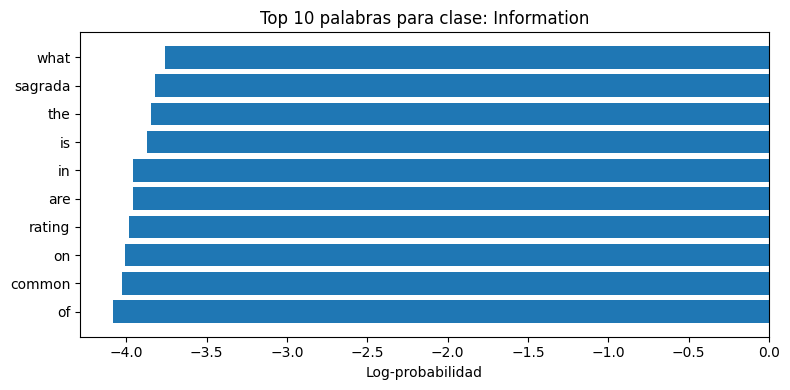

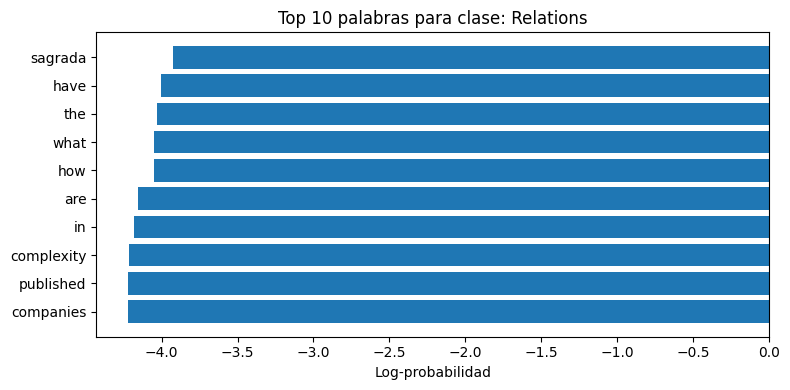

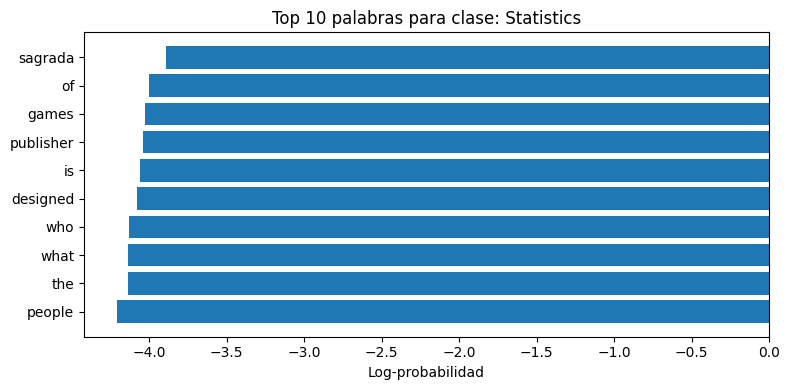

In [50]:
vectorizer = model.named_steps['tfidfvectorizer']
classifier = model.named_steps['multinomialnb']

# Obtener nombres de características y pesos por clase
feature_names = vectorizer.get_feature_names_out()
class_labels = classifier.classes_
feature_log_probs = classifier.feature_log_prob_

# Graficar top 10 palabras por clase
for i, label in enumerate(class_labels):
    top_indices = np.argsort(feature_log_probs[i])[-10:]
    top_words = feature_names[top_indices]
    top_scores = feature_log_probs[i][top_indices]

    plt.figure(figsize=(8, 4))
    plt.barh(top_words, top_scores)
    plt.title(f"Top 10 palabras para clase: {label}")
    plt.xlabel("Log-probabilidad")
    plt.tight_layout()
    plt.show()

### Modelo Bert

In [58]:
import os
os.environ["WANDB_DISABLED"] = "true"  # Deshabilita wandb para que no pida API key ni haga logging externo

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import Trainer, TrainingArguments, BertTokenizerFast
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Cargar el CSV con las preguntas y sus categorías
df = pd.read_csv("sagrada_questions.csv")

# Cambiar nombres de columnas para simplificar
df = df.rename(columns={"Question": "text", "Category": "label"})

# Convertir etiquetas de texto a números (factorizar)
labels, uniques = pd.factorize(df["label"])
df["label"] = labels

# Dividir en conjuntos de entrenamiento y prueba (80%-20%)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

# Cargar tokenizer BERT base uncased
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Tokenizar los textos (cortar y rellenar para que tengan igual tamaño)
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

# Crear datasets compatibles con Trainer, con input_ids, atención y etiquetas
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels
})

test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_labels
})

# Cargar modelo BERT para clasificación, con la cantidad correcta de etiquetas
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(uniques))

# Función para calcular métricas que se usarán durante la evaluación
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)  # Obtener predicciones como la clase con mayor probabilidad
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted")
    }

# Parámetros de entrenamiento sin evaluation_strategy ni load_best_model_at_end
training_args = TrainingArguments(
    output_dir="./results",              # Carpeta para guardar resultados
    num_train_epochs=3,                  # Número de épocas
    per_device_train_batch_size=16,     # Tamaño de batch para entrenamiento
    per_device_eval_batch_size=16,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

# Crear el objeto Trainer con el modelo, argumentos y datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Entrenar el modelo
trainer.train()

# Evaluar el modelo y mostrar resultados
results = trainer.evaluate()
print(results)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.093200
20,0.831700
30,0.601700
40,0.340300


{'eval_loss': 0.04371862858533859, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 0.1347, 'eval_samples_per_second': 475.153, 'eval_steps_per_second': 29.697, 'epoch': 3.0}
